L'objectif de ce notebook est d'illustrer le fonctionnement d'un autoencodeur. Les autoencodeurs sont principalement des algorithmes de réduction de dimensions (on passe d'un grand nombre de dimensions pour, au centre de l'autoencodeur,réduire ce nombre de dimension). Cependant ils ont de nombreuses propriétés :     
* Spéficiques aux données : ils ne peuvent compresser (réduire) que le type de données sur lesquels ils ont été appris. 
* Sortie dégradée : malheureusement la sortie ne sera pas aussi bien que l'entrée. La représentation sera proche mais un peu dégradée. 
* Non supervisé (ou plutôt *self-supervised*) : pour apprendre il n'est pas nécessaire d'avoir des données labelisées. Ce sont les données elles-mêmes qui sont utilisées. Généralement on parle plutôt de *self-supervised* car on "génère les labels" à partir des données d'apprentissage. 

## Installation

Avant de commencer, il est nécessaire de déjà posséder dans son environnement toutes les librairies utiles. Dans la seconde cellule nous importons toutes les librairies qui seront utiles à ce notebook. Il se peut que, lorsque vous lanciez l'éxecution de cette cellule, une soit absente. Dans ce cas il est nécessaire de l'installer. Pour cela dans la cellule suivante utiliser la commande :
! pip install nom_librairie
Attention : il est fortement conseillé lorsque l'une des librairies doit être installer de relancer le kernel de votre notebook.
Remarque : même si toutes les librairies sont importées dès le début, les librairies utiles pour des fonctions présentées au cours de ce notebook sont ré-importées de manière à indiquer d'où elles viennent et ainsi faciliter la réutilisation de la fonction dans un autre projet.


In [11]:
# utiliser cette cellule pour installer les librairies manquantes
# pour cela il suffit de taper dans cette cellule : !pip install nom_librairie_manquante
# d'exécuter la cellule et de relancer la cellule suivante pour voir si tout se passe bien
# recommencer tant que toutes les librairies ne sont pas installées ...

In [12]:
from keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D
from keras import Input, Model
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
from tensorflow.keras.layers import Dense, BatchNormalization
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model

Pour pouvoir sauvegarder sur votre répertoire Google Drive, il est nécessaire de fournir une autorisation. Pour cela il suffit d'éxecuter la ligne suivante et de saisir le code donné par Google.

In [13]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Corriger éventuellement la ligne ci-dessous pour mettre le chemin vers un répertoire spécifique dans votre répertoire Google Drive :

In [14]:
import sys
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/ML_FDS'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd

/content/gdrive/My Drive/Colab Notebooks/ML_FDS


'/content/gdrive/My Drive/Colab Notebooks/ML_FDS'

Chargement des données

In [15]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


L'autoencodeur va comporter deux parties :     
* L'encodeur : ici nous allons avoir 2 couches de convolutions et un 2 maxPoolings. L'entrée est composée d'une image de 28x28. L'objectif de l'encodeur est via les couches de pooling de "sous-échantilloner" (en d'autres termes réduire le plus possible la taille de l'image).
* Le décodeur : il est composé de deux couches de convolutions mais aussi de deux couches de Upsampling. Les images en entrée ont été sous échantillonnées par les couches de maxpooling. Il faut à présent les augmenter. C'est l'objectif de Upsampling. Upsampling fonctionne en répetant les lignes et les colonnes de l'entrée. Ainsi une image de 2x2 donnera avec un UpSampling (2) une image de 4x4.
* Couche de sortie  : en fait cette couche fait partie du découdeur au même titre que la couche d'entrée fait partie de l'encodeur. Nous la mettons en évidence pour bien comprendre qu'il est indispensable d'avoir une couche de sortie pour propager la descente de gradient. L'objectif est d'avoir une fonction de loss pour comparer les entrées aux sorties et justement pouvoir propager les descentes de gradients

In [16]:
model = Sequential()
# Partie encodeur
model.add(Conv2D(30, 3, activation= 'relu', padding='same', input_shape = (28,28,1)))
model.add(MaxPooling2D(2, padding= 'same'))
model.add(Conv2D(15, 3, activation= 'relu', padding='same'))
model.add(MaxPooling2D(2, padding= 'same'))

# Partie décodeur 
model.add(Conv2D(15, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))
model.add(Conv2D(30, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))

# Couche de sortie
model.add(Conv2D(1,3,activation='sigmoid', padding= 'same')) 
model.compile(optimizer= 'adam', loss = 'binary_crossentropy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 30)        300       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 30)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 15)        4065      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 15)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 15)          2040      
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 15)       0

Le traitement est assez similaire à celui d'un MLP. Il faut normaliser les données. La différence essentielle est dans l'appel de la fonction *fit*. D'habitude pour apprendre le modèle on utilise :     

    model.fit (X_train, y_train, ...  

Ici nous n'avons pas de y_train (les données ne sont pas labelisées). En fait ce que nous voulons c'est que les données de sorties soient le plus proche possible des données d'entrées. Pour cela, nous allons utiliser :     

    model.fit (X_train, X_train, ...

Bien entendu il faut faire la même chose pour le jeu de validation :     

    validation_data=(X_test, X_test) à la place de validation_data=(X_test, y_test)

Grâce à cela le modèle va pouvoir comparer les données d'entrées et de sorties.     

Par rapport au modèle que nous avons défini, la sortie du modèle utilise une sigmoid comme fonction d'activation, le modèle va se comporter comme un classifieur classique (évaluation de la loss, ici binary_cross_entropy : les images sont similaires ou non ? ) et va propager l'erreur dans tout le réseau. 

In [17]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = np.reshape(X_train, (len(X_train), 28, 28, 1))
X_test = np.reshape(X_test, (len(X_test), 28, 28, 1))


**CO2 !!! Remarque IMPORTANTE** Pour gagner du temps, éviter de relancer l'apprentissage et du CO2 un modèle appris est disponible. Nous l'utilisons juste après. Si vous voulez le lancer il faut enlever les commentaires dans la cellule ci-dessous.

In [18]:
#model.fit(X_train, X_train,
#                epochs=15,
#                batch_size=128,
#                validation_data=(X_test, X_test))

In [19]:
!wget https://www.lirmm.fr/~poncelet/Ressources/modelCNNFashionMnist.h5

--2022-09-29 20:42:31--  https://www.lirmm.fr/~poncelet/Ressources/modelCNNFashionMnist.h5
Resolving www.lirmm.fr (www.lirmm.fr)... 193.49.104.251
Connecting to www.lirmm.fr (www.lirmm.fr)|193.49.104.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1722768 (1.6M) [text/plain]
Saving to: ‘modelCNNFashionMnist.h5.2’

modelCNNFashionMnis 100%[===================>]   1.64M  2.78MB/s    in 0.6s    

2022-09-29 20:42:33 (2.78 MB/s) - ‘modelCNNFashionMnist.h5.2’ saved [1722768/1722768]



Il suffit de charger le modèle :      

In [20]:
model = load_model('AutoencodeurFashionMNIST.h5')

Il est donc tout à fait possible de voir la sortie de l'autoencoder en utilisant comme classiquement la méthode *predict* :     

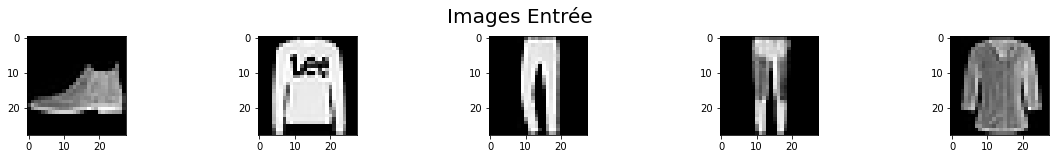

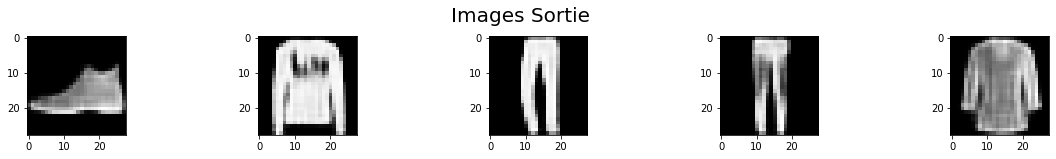

In [21]:
pred = model.predict(X_test)
fig = plt.figure(figsize=(20,4))
fig.suptitle("Images Entrée" , fontsize=20)
for i in range(5):
    # Display original
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
plt.show()

fig = plt.figure(figsize=(20,4))
fig.suptitle("Images Sortie" , fontsize=20)
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(pred[i].reshape(28, 28))
    plt.gray()
plt.show()


###Utiliser un autoencodeur pour enlever le bruit d'une image une image ou pour transformer une image en noir en blanc en couleur

Dans cette partie nous montrons comment un autoencodeur peut être utilisé pour enlever du bruit sur une image. C'est ce principe qui est utilisé pour, par exemple, colorer des images, mettre un style particulier sur une image, etc.     

Dans un premier temps nous mettons du bruit dans les images. 

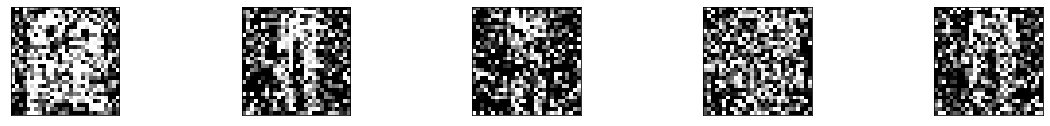

In [22]:
noise_factor = 0.7
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)
# Voici à quoi ressemble les images avec du bruit.
plt.figure(figsize=(20, 2))
for i in range(1, 5 + 1):
    ax = plt.subplot(1, 5, i)
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Nous pouvons utiliser le même modèle que précédemment :      

In [23]:
model = Sequential()
# Partie encodeur
model.add(Conv2D(35, 3, activation= 'relu', padding='same', input_shape = (28,28,1)))
model.add(MaxPooling2D(2, padding= 'same'))
model.add(Conv2D(25, 3, activation= 'relu', padding='same'))
model.add(MaxPooling2D(2, padding= 'same'))
# Partie décodeur
model.add(Conv2D(25, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))
model.add(Conv2D(35, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))
model.add(Conv2D(1,3,activation='sigmoid', padding= 'same')) 
model.compile(optimizer= 'adam', loss = 'binary_crossentropy')


Pour apprendre le modèle il suffit simplement de passer des images bruitées en entrée et des images nettes en sortie (i.e., à la place du y_train). 

**CO2 !!! Remarque IMPORTANTE** Pour gagner du temps, éviter de relancer l'apprentissage et du CO2 un modèle appris est disponible. Nous l'utilisons juste après. Si vous voulez le lancer il faut enlever les commentaires dans la cellule ci-dessous.

In [24]:
#model.fit(X_train_noisy, X_train,
#                epochs=15,
#                batch_size=128,
#                validation_data=(X_test_noisy, X_test))

Télécharger le modèle déjà appris

In [25]:
!wget https://www.lirmm.fr/~poncelet/Ressources/AutoencodeurNoise.h5

--2022-09-29 20:42:47--  https://www.lirmm.fr/~poncelet/Ressources/AutoencodeurNoise.h5
Resolving www.lirmm.fr (www.lirmm.fr)... 193.49.104.251
Connecting to www.lirmm.fr (www.lirmm.fr)|193.49.104.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322532 (315K) [text/plain]
Saving to: ‘AutoencodeurNoise.h5.1’

AutoencodeurNoise.h 100%[===================>] 314.97K   641KB/s    in 0.5s    

2022-09-29 20:42:48 (641 KB/s) - ‘AutoencodeurNoise.h5.1’ saved [322532/322532]



Il suffit de charger le modèle :           

In [26]:
model = load_model('AutoencodeurNoise.h5')

Pour voir comment le bruit est enlevé d'une image, il suffit de passer une image bruitée et le modèle va enlever le bruit. 

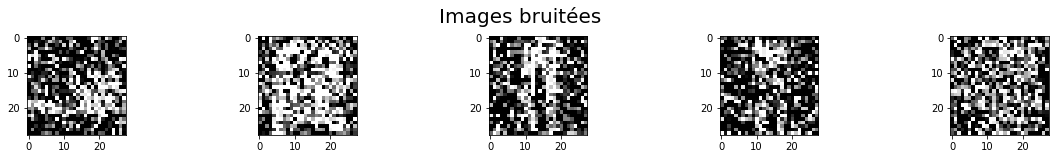

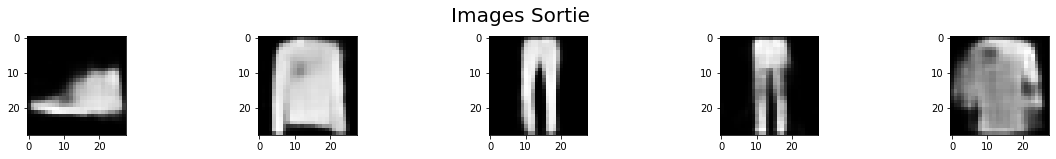

In [27]:
pred = model.predict(X_test_noisy)

fig = plt.figure(figsize=(20,4))
fig.suptitle("Images bruitées" , fontsize=20)
for i in range(5):
    # Display original
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()
plt.show()

fig = plt.figure(figsize=(20,4))
fig.suptitle("Images Sortie" , fontsize=20)
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(pred[i].reshape(28, 28))
    plt.gray()
plt.show()




**Et pour colorier des images en noir et blanc** ... rien de plus simple : il faut un jeu de données d'images en noir et blanc et en couleur. Dans le fit il suffira de passer fit(train_noir_et_blanc, train_couleur .... ) et vous obtenez un autoencodeur capable de transformer automatiquement des images en noir en blanc en images couleurs.   

**Et pour traduire du texte ?** : seq2seq est un autoencodeur optimisé (utilisation de LSTM, attention) mais le principe est le même : fit(langue_origine, langue_destination, ....)

**Et pour générer des images ou du texte ?** : les autoencoders ne sont pas adaptés. Leur objectif est de "comprimer les données. Cela veut dire qu'au niveau du Latent Space nous avons peu d'information sur la distribution des données. Il faut passer par des **variational auto encodeurs** qui avant de créer le latent space vont aussi prendre en compte la manière dont les données sont distribuées.